In [49]:
# Fake News Detection using NLP

"""
Business Use Case:
- Detect fake news automatically before it spreads
- Help social media platforms moderate content
- Protect users from misinformation during elections, pandemics, or financial news
"""

'\nBusiness Use Case:\n- Detect fake news automatically before it spreads\n- Help social media platforms moderate content\n- Protect users from misinformation during elections, pandemics, or financial news\n'

In [62]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.makedirs("images", exist_ok=True)

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [47]:
DATA_PATH = "./liar_dataset"

columns = [
    "id", "label", "statement", "subject", "speaker",
    "job", "state", "party",
    "barely_true", "false", "half_true",
    "mostly_true", "pants_fire", "context"
]

train_df = pd.read_csv(os.path.join(DATA_PATH, "train.tsv"), sep="\t", names=columns)
valid_df = pd.read_csv(os.path.join(DATA_PATH, "valid.tsv"), sep="\t", names=columns)
test_df  = pd.read_csv(os.path.join(DATA_PATH, "test.tsv"), sep="\t", names=columns)

In [16]:
fake_labels = ["false", "pants-fire", "barely-true"]
real_labels = ["half-true", "mostly-true", "true"]

def map_label(label):
    if label in fake_labels:
        return 0
    elif label in real_labels:
        return 1
    else:
        return None

train_df["target"] = train_df["label"].apply(map_label)
valid_df["target"] = valid_df["label"].apply(map_label)
test_df["target"]  = test_df["label"].apply(map_label)

train_df = train_df.dropna(subset=["target"])
valid_df = valid_df.dropna(subset=["target"])
test_df  = test_df.dropna(subset=["target"])

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z ]", "", text)
    return text

train_df["statement"] = train_df["statement"].apply(clean_text)
valid_df["statement"] = valid_df["statement"].apply(clean_text)
test_df["statement"]  = test_df["statement"].apply(clean_text)

In [ ]:
train_df[["statement", "label"]].head()

,statement,label
0,says the annies list political group supports ...,false
1,when did the decline of coal start it started ...,half-true
2,hillary clinton agrees with john mccain by vot...,mostly-true
5,the chicago bears have had more starting quart...,true
7,im the only person on this stage who has worke...,half-true


In [26]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df["statement"])
X_valid = vectorizer.transform(valid_df["statement"])
X_test  = vectorizer.transform(test_df["statement"])

y_train = train_df["target"]
y_valid = valid_df["target"]
y_test  = test_df["target"]


In [27]:
print(y_train.value_counts())

target
1    5752
0    4488
Name: count, dtype: int64


In [29]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df["statement"])
X_valid = vectorizer.transform(valid_df["statement"])
X_test  = vectorizer.transform(test_df["statement"])

In [30]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [31]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.7,
    ngram_range=(1, 2)
)

X_train = vectorizer.fit_transform(train_df["statement"])
X_valid = vectorizer.transform(valid_df["statement"])
X_test  = vectorizer.transform(test_df["statement"])


In [32]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(10240, 80883)
(1284, 80883)
(1267, 80883)


In [33]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, train_df["target"])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [35]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

Accuracy: 0.611681136543015
              precision    recall  f1-score   support

        Fake       0.56      0.54      0.55       553
        Real       0.65      0.67      0.66       714

    accuracy                           0.61      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.61      0.61      0.61      1267



In [ ]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[:20]
top_real = np.argsort(coefficients)[-20:]

print("Top words for FAKE news:\n")
for i in top_fake:
    print(feature_names[i])

print("\nTop words for REAL news:\n")
for i in top_real:
    print(feature_names[i])

Top words for FAKE news:

obamacare
says
wisconsin
away
government
illegal
women
care law
policies
virginias
says barack
president
obama
know
pass
care
barack obama
gotten
abortion
ken

Top words for REAL news:

washington
twothirds
decades
workers
day
today
ohio
highest
weve
mccain
lowest
half
average
countries
rate
times
debt
months
million
percent


In [ ]:
def predict_news(text):
    text = clean_text(text)
    vector = vectorizer.transform([text])
    prediction = model.predict(vector)[0]
    return "REAL NEWS ✅" if prediction == 1 else "FAKE NEWS ❌"

predict_news("The government announced a new health policy today")

'REAL NEWS ✅'

In [ ]:
predict_news("This miracle drink cures all diseases instantly")

'FAKE NEWS ❌'

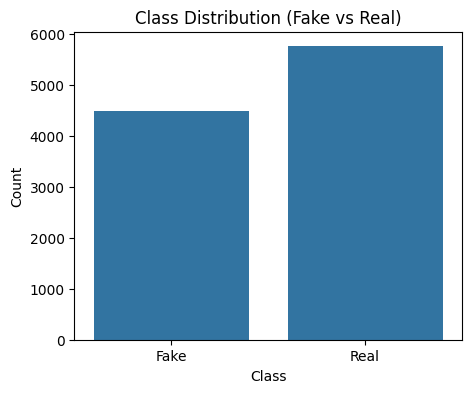

In [64]:
plt.figure(figsize=(5,4))
sns.countplot(x=train_df["target"])
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Class Distribution (Fake vs Real)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.savefig("images/class_distribution.png", bbox_inches="tight")
plt.show()

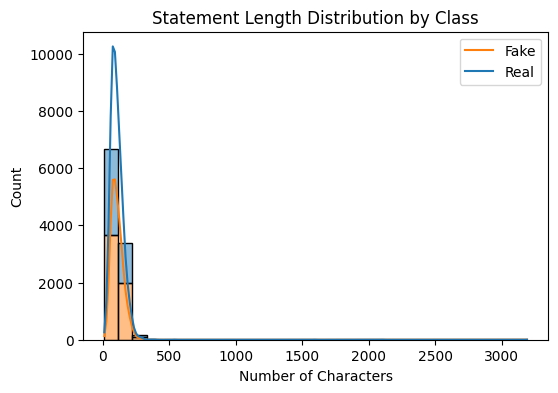

In [66]:
train_df["text_length"] = train_df["statement"].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(
    data=train_df,
    x="text_length",
    hue="target",
    bins=30,
    kde=True,
    multiple="stack"
)
plt.title("Statement Length Distribution by Class")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.legend(labels=["Fake", "Real"])
plt.savefig("images/Statement Length Distribution by Class.png", bbox_inches = "tight")
plt.show()

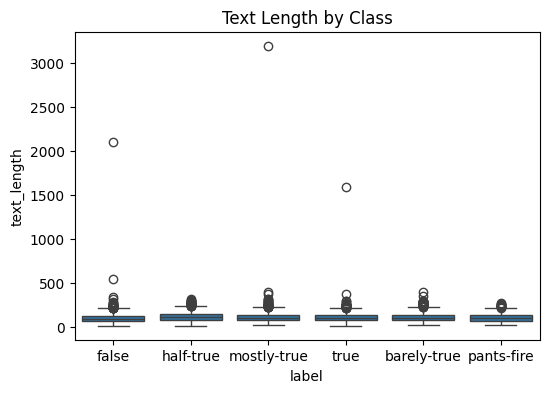

In [68]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="text_length", data=train_df)
plt.title("Text Length by Class")
plt.savefig("images/Text Length by Class.png", bbox_inches = "tight")
plt.show()

In [38]:
from collections import Counter

fake_words = " ".join(train_df[train_df["target"] == 0]["statement"]).split()
real_words = " ".join(train_df[train_df["target"] == 1]["statement"]).split()

fake_common = Counter(fake_words).most_common(10)
real_common = Counter(real_words).most_common(10)

print("Fake News Common Words:", fake_common)
print("Real News Common Words:", real_common)

Fake News Common Words: [('the', 3403), ('to', 2122), ('of', 1808), ('in', 1788), ('a', 1487), ('and', 1103), ('Says', 1088), ('for', 894), ('that', 796), ('is', 782)]
Real News Common Words: [('the', 5025), ('of', 2937), ('in', 2873), ('to', 2313), ('a', 1907), ('and', 1609), ('Says', 1161), ('for', 1108), ('that', 977), ('is', 964)]


In [39]:
train_df["target"].value_counts()

,count
target,
1,5752
0,4488


In [40]:
train_df["text_length"] = train_df["statement"].apply(len)

train_df.groupby("target")["text_length"].mean()

,text_length
target,
0,104.195410
1,109.043637


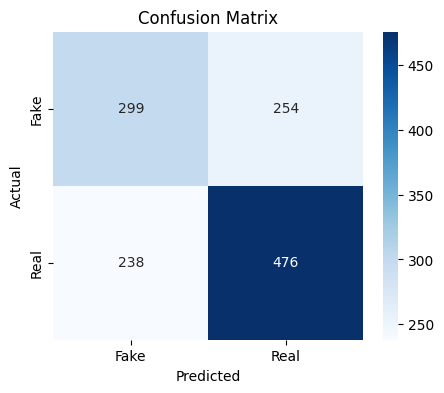

In [69]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake","Real"], yticklabels=["Fake","Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("images/Confusion Matrix.png", bbox_inches = "tight")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Fake","Real"]))


              precision    recall  f1-score   support

        Fake       0.50      0.51      0.51       349
        Real       0.66      0.65      0.65       504

    accuracy                           0.59       853
   macro avg       0.58      0.58      0.58       853
weighted avg       0.59      0.59      0.59       853



In [42]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[:20]
top_real = np.argsort(coefficients)[-20:]

print("Top words for FAKE news:")
for i in top_fake:
    print(feature_names[i])

print("\nTop words for REAL news:")
for i in top_real:
    print(feature_names[i])

Top words for FAKE news:
obamacare
wisconsin
obama
rep
says
government
scott walker
obamas
walker
away
care law
plan
president
care
white
illegal
stimulus
group
muslim
scott

Top words for REAL news:
cities
lower
terms
americans
60
cut
000
american
country
half
highest
months
debt
times
average
million
georgia
day
countries
percent


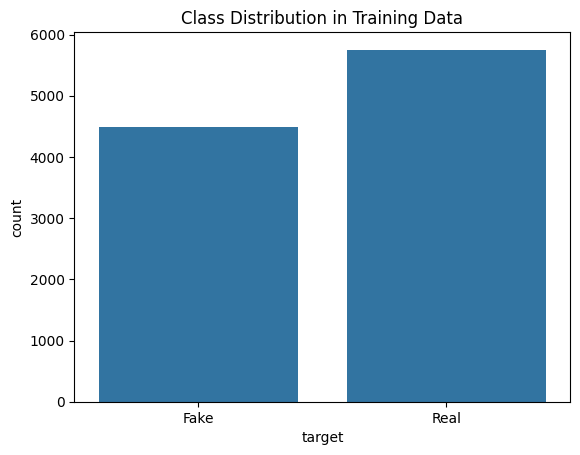

In [70]:
sns.countplot(x="target", data=train_df)
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Class Distribution in Training Data")
plt.savefig("images/Class Distribution in Training Data.png", bbox_inches = "tight")
plt.show()

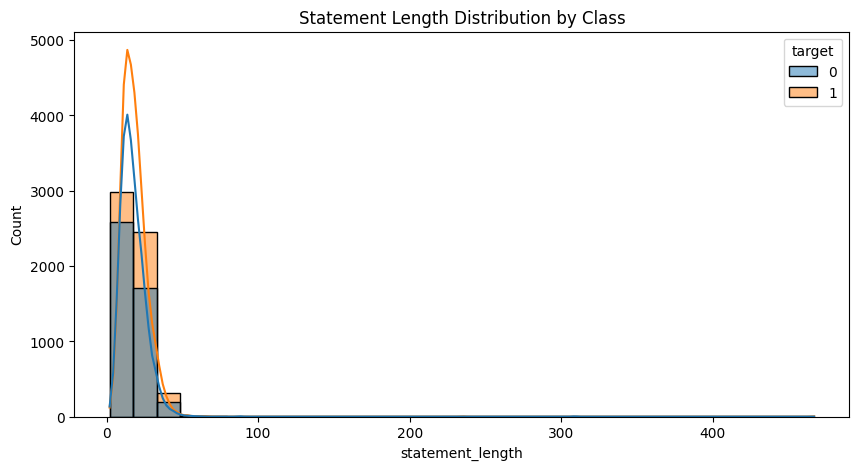

In [71]:
train_df["statement_length"] = train_df["statement"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(train_df, x="statement_length", hue="target", bins=30, kde=True)
plt.title("Statement Length Distribution by Class")
plt.savefig("images/Statement Length Distribution by Class.png", bbox_inches = "tight")
plt.show()

In [45]:
from collections import Counter

stopwords = set(ENGLISH_STOP_WORDS)

fake_words = [
    w for w in ' '.join(train_df[train_df["target"]==0]["statement"]).split()
    if w not in stopwords
]

real_words = [
    w for w in ' '.join(train_df[train_df["target"]==1]["statement"]).split()
    if w not in stopwords
]

print("Top words in FAKE news:")
print(Counter(fake_words).most_common(20))

print("\nTop words in REAL news:")
print(Counter(real_words).most_common(20))

Top words in FAKE news:
[('Says', 1088), ('The', 527), ('Obama', 338), ('percent', 280), ('health', 272), ('tax', 247), ('people', 236), ('state', 232), ('I', 231), ('President', 214), ('care', 204), ('Barack', 198), ('U.S.', 194), ('voted', 176), ('million', 158), ('billion', 156), ('In', 152), ('We', 146), ('said', 146), ('federal', 135)]

Top words in REAL news:
[('Says', 1161), ('The', 726), ('percent', 685), ('state', 357), ('tax', 331), ('million', 300), ('people', 293), ('Obama', 281), ('health', 266), ('I', 253), ('In', 246), ('U.S.', 213), ('jobs', 209), ('We', 206), ('United', 202), ('year', 193), ('federal', 188), ('years', 185), ('Texas', 185), ('President', 182)]


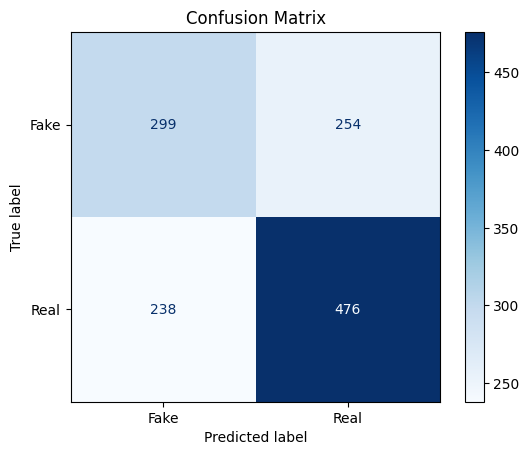

In [72]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("images.Confusion Matrix.png",bbox_inches = "tight")
plt.show()

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

Classification Report:

              precision    recall  f1-score   support

        Fake       0.50      0.51      0.51       349
        Real       0.66      0.65      0.65       504

    accuracy                           0.59       853
   macro avg       0.58      0.58      0.58       853
weighted avg       0.59      0.59      0.59       853



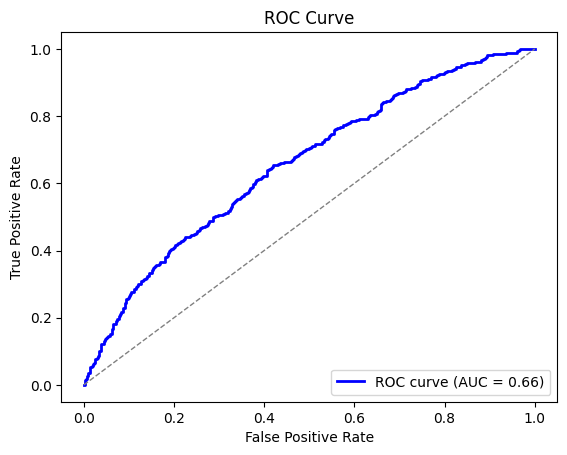

In [73]:
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("images.ROC Curve.png",bbox_inches = "tight")
plt.show()

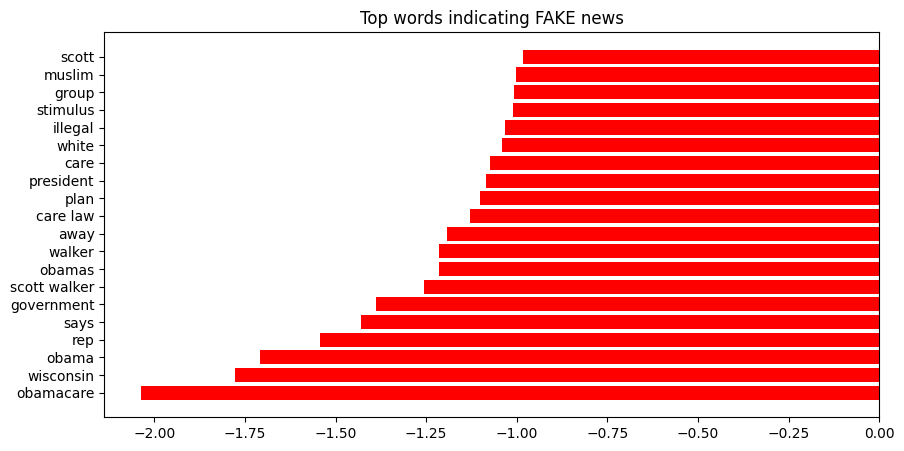

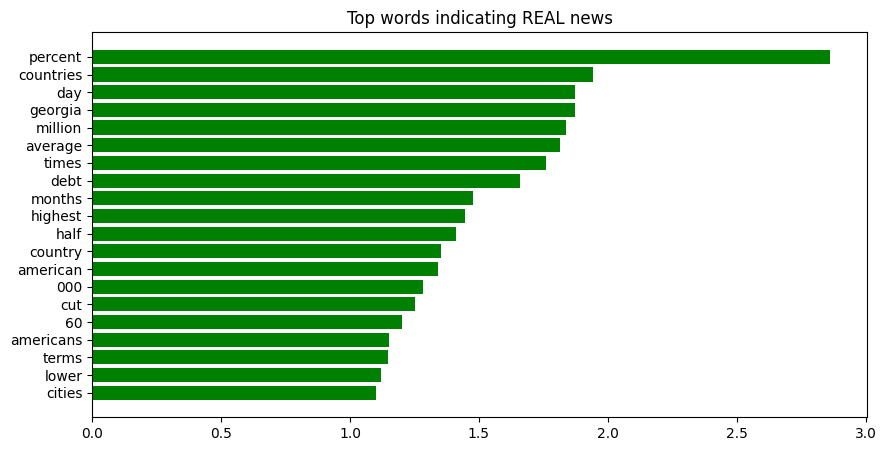

In [74]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

top_fake_idx = np.argsort(coefficients)[:20]
top_real_idx = np.argsort(coefficients)[-20:]

plt.figure(figsize=(10,5))
plt.barh([feature_names[i] for i in top_fake_idx], coefficients[top_fake_idx], color='red')
plt.title("Top words indicating FAKE news")
plt.show()

plt.figure(figsize=(10,5))
plt.barh([feature_names[i] for i in top_real_idx], coefficients[top_real_idx], color='green')
plt.title("Top words indicating REAL news")
plt.savefig("images.Top words indicating FAKE news.png",bbox_inches = "tight")
plt.show()


In [53]:
"""
Conclusion

- A Logistic Regression model with TF-IDF features was trained to detect fake news.
- The model achieved ~59% accuracy on the test set.
- Feature importance analysis shows politically relevant terms strongly influence predictions.
- This model can be extended using deep learning or contextual embeddings (BERT) for better performance.
"""

'\nConclusion\n\n- A Logistic Regression model with TF-IDF features was trained to detect fake news.\n- The model achieved ~59% accuracy on the test set.\n- Feature importance analysis shows politically relevant terms strongly influence predictions.\n- This model can be extended using deep learning or contextual embeddings (BERT) for better performance.\n'